This notebook gives helper functions and starter code to get on the leaderboard. We recommend you to first read about the [challenge](http://cvpr2022.ug2challenge.org/dataset22_t1.html) before you go through this notebook.

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/COMS4995_Competition

/content/drive/.shortcut-targets-by-id/1NQ6kbfawC4kjJNbWUW0uuMYnJQJg17UW/COMS4995_Competition


**Import Libraries**

In [3]:
import os
from glob import glob
from pathlib import Path
from collections import defaultdict
from pprint import pprint
from random import choice, sample
import cv2
import PIL
from PIL import Image

Make sure you upload the train folder to your google drive. Training data used in the code can be found [here](http://cvpr2022.ug2challenge.org/dataset22_t1.html).

**Folder Structure and Directory Setup**

ObjectDetection.ipynb

train

 -clean_images

 -clean_images_labels

 -dry-run

 -haze_images

 -haze_images_labels

The aim is to detect the objects present in an input image. You might be wondering what exactly do you mean by detecting? Given an input image we need to output a set of coordinates that represents a bounding box enclosing the object of interest. The object of interest in this challenge is a vehicle. There can be multiple objects as well. Your output therefore is a list of bounding boxes represented as a tuple or a list of coordinates. To add to the difficulty the input image is not a clear image. Again all these details are present in the challenge link.

In [ ]:
#Change this path to your path to your train folder
root = 'COMS4995_Competition/train'

In [ ]:
haze_images = os.path.join(root, 'haze_images')
haze_images_labels = os.path.join(root, 'haze_images_labels')

#Not used in the starter notebook. Feel free to use it
clean_images = os.path.join(root, 'clean_images')
clean_images_labels = os.path.join(root, 'clean_images_labels')

The following assertion should pass if the root path is set properly and the train folder is uploaded to your google drive.

In [ ]:
assert os.path.exists(haze_images), 'Check the path to your root directory'
assert os.path.exists(haze_images_labels), 'Check the path to your root directory'

If you take a look at the haze_images directory. There are a total of 177 images. Images have a format of a number with three digits and the file extension. Example : 000.jpg, 001.jpg etc. We will consider images having number greater than 170 to be in the validation set which approximately forms
10% of the total images. You can experiment with this number to have a different training and validation split. You can definitely modify the train and validation split by using your own logic or using any of the popular deep learning libraries.

In [ ]:
#Image with name greater or equal to 170 will be considered as validation images.
#Example 170.jpg, 173.jpg etc
val_cutoff = 170

In [ ]:
all_haze_images = glob(haze_images + "/*.jpg")

train_images = [x for x in all_haze_images if int(Path(x).stem) < val_cutoff]
val_images = [x for x in all_haze_images if int(Path(x).stem) >= val_cutoff]


print('Number of traing images :', len(train_images))
print('Number of validation images :', len(val_images))

assert len(train_images) + len(val_images) == len(all_haze_images)

Number of traing images : 159
Number of validation images : 18


In [ ]:
def get_images_bb_map(images_list):
  '''
    Returns the mapping of image path with the ground truth bounding box coords.
    This method fetches the coordinates of the bounding box from the haze_image_labels
    directory.
            Parameters:
                    images_list : List of images

            Returns:
                    train_images_box_map : A dictionary with Image path as the key and 
                    the value is the list of detected objects with each item in a list being
                    a list of coordinates which identifies the bounding box of the detected object
                    in the image
    '''
  images_box_map = defaultdict(list) #
  for x in images_list:
    img_without_extention = Path(x)
    haze_image_label = os.path.join(haze_images_labels, f'{img_without_extention.stem}.txt')
    f = open(haze_image_label, "r")
    lines = f.read().strip().split('\n')
    for line in lines:
      line_text = line.strip().split(' ')
      assert len(line_text) == 5, 'Each line must have 5 values' #one identifer and 4 coordinates
      coords = line_text[1:]
      images_box_map[x].append(coords)
  return images_box_map

Let's get the mapping of image and the detected objects in a single dictionary data structure.

In [ ]:
train_images_box_map = get_images_bb_map(train_images)
val_images_box_map = get_images_bb_map(val_images)

assert len(train_images_box_map) == len(train_images)
assert len(val_images_box_map) == len(val_images)

The example image below has six vehicles.
Let's print one of the items in the dictionary to get a feel for the data.

In [ ]:
example_train_image = list(train_images_box_map.keys())[0]
print('Key :', example_train_image)
print('Value')
pprint(train_images_box_map[example_train_image])

Key : COMS4995_Competition/train/haze_images/003.jpg
Value
[['625', '240', '749', '419'],
 ['653', '686', '722', '749'],
 ['351', '733', '527', '749']]


Here we are defining an example data generator. Here our data generator will generate a batch of examples which will be used by your model in training. It will generate a list of 'batch_size' images. Each item being a tuple of image numpy array and corresponding detected object's list of coordinates.

**Example Data generator**

In [ ]:
from keras.preprocessing import image
import numpy as np

def read_img(path):
    '''
    Returns the image as a numpy array
            Parameters:
                    path : Path of the image

            Returns:
                    img : numpy representation of the image
    '''
    img = image.load_img(path)
    img = np.array(img).astype(np.float)
    return img

In [ ]:
def gen(images_to_bb_map, batch_size=16):
    '''
    Returns the generator of list of tuples of image numpy array with
    the bounding box coordinates
            Parameters:
                    images_to_bb_map : A dictionary with key as the image path and
                    value as the list of bounding box coordinates.
            Returns:
                    (image, [bounding box coordinates]) : a list of tuples. The first
                    item in the tuple is a numpy array of the image and the second item
                    is a list of bounding box coordinates
    '''

    images = list(images_to_bb_map.keys())
    while True:
        batch_images = sample(images, batch_size)
        ret = []
        for image in batch_images:
          ret.append((read_img(image), images_to_bb_map[image]))
        yield ret

In [ ]:
for t in gen(train_images_box_map):
  print(len(t))
  print('Image shape : ', t[0][0].shape)
  pprint(t[0][1])
  break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


16
Image shape :  (1500, 1845, 3)
[['825', '452', '954', '672'],
 ['1079', '652', '1200', '749'],
 ['1422', '645', '1603', '749'],
 ['490', '0', '691', '221'],
 ['545', '360', '739', '509']]


As you can see there are 16 images and the images have their corresponding bounding box.

**Visualizing images**

In [ ]:
from google.colab.patches import cv2_imshow

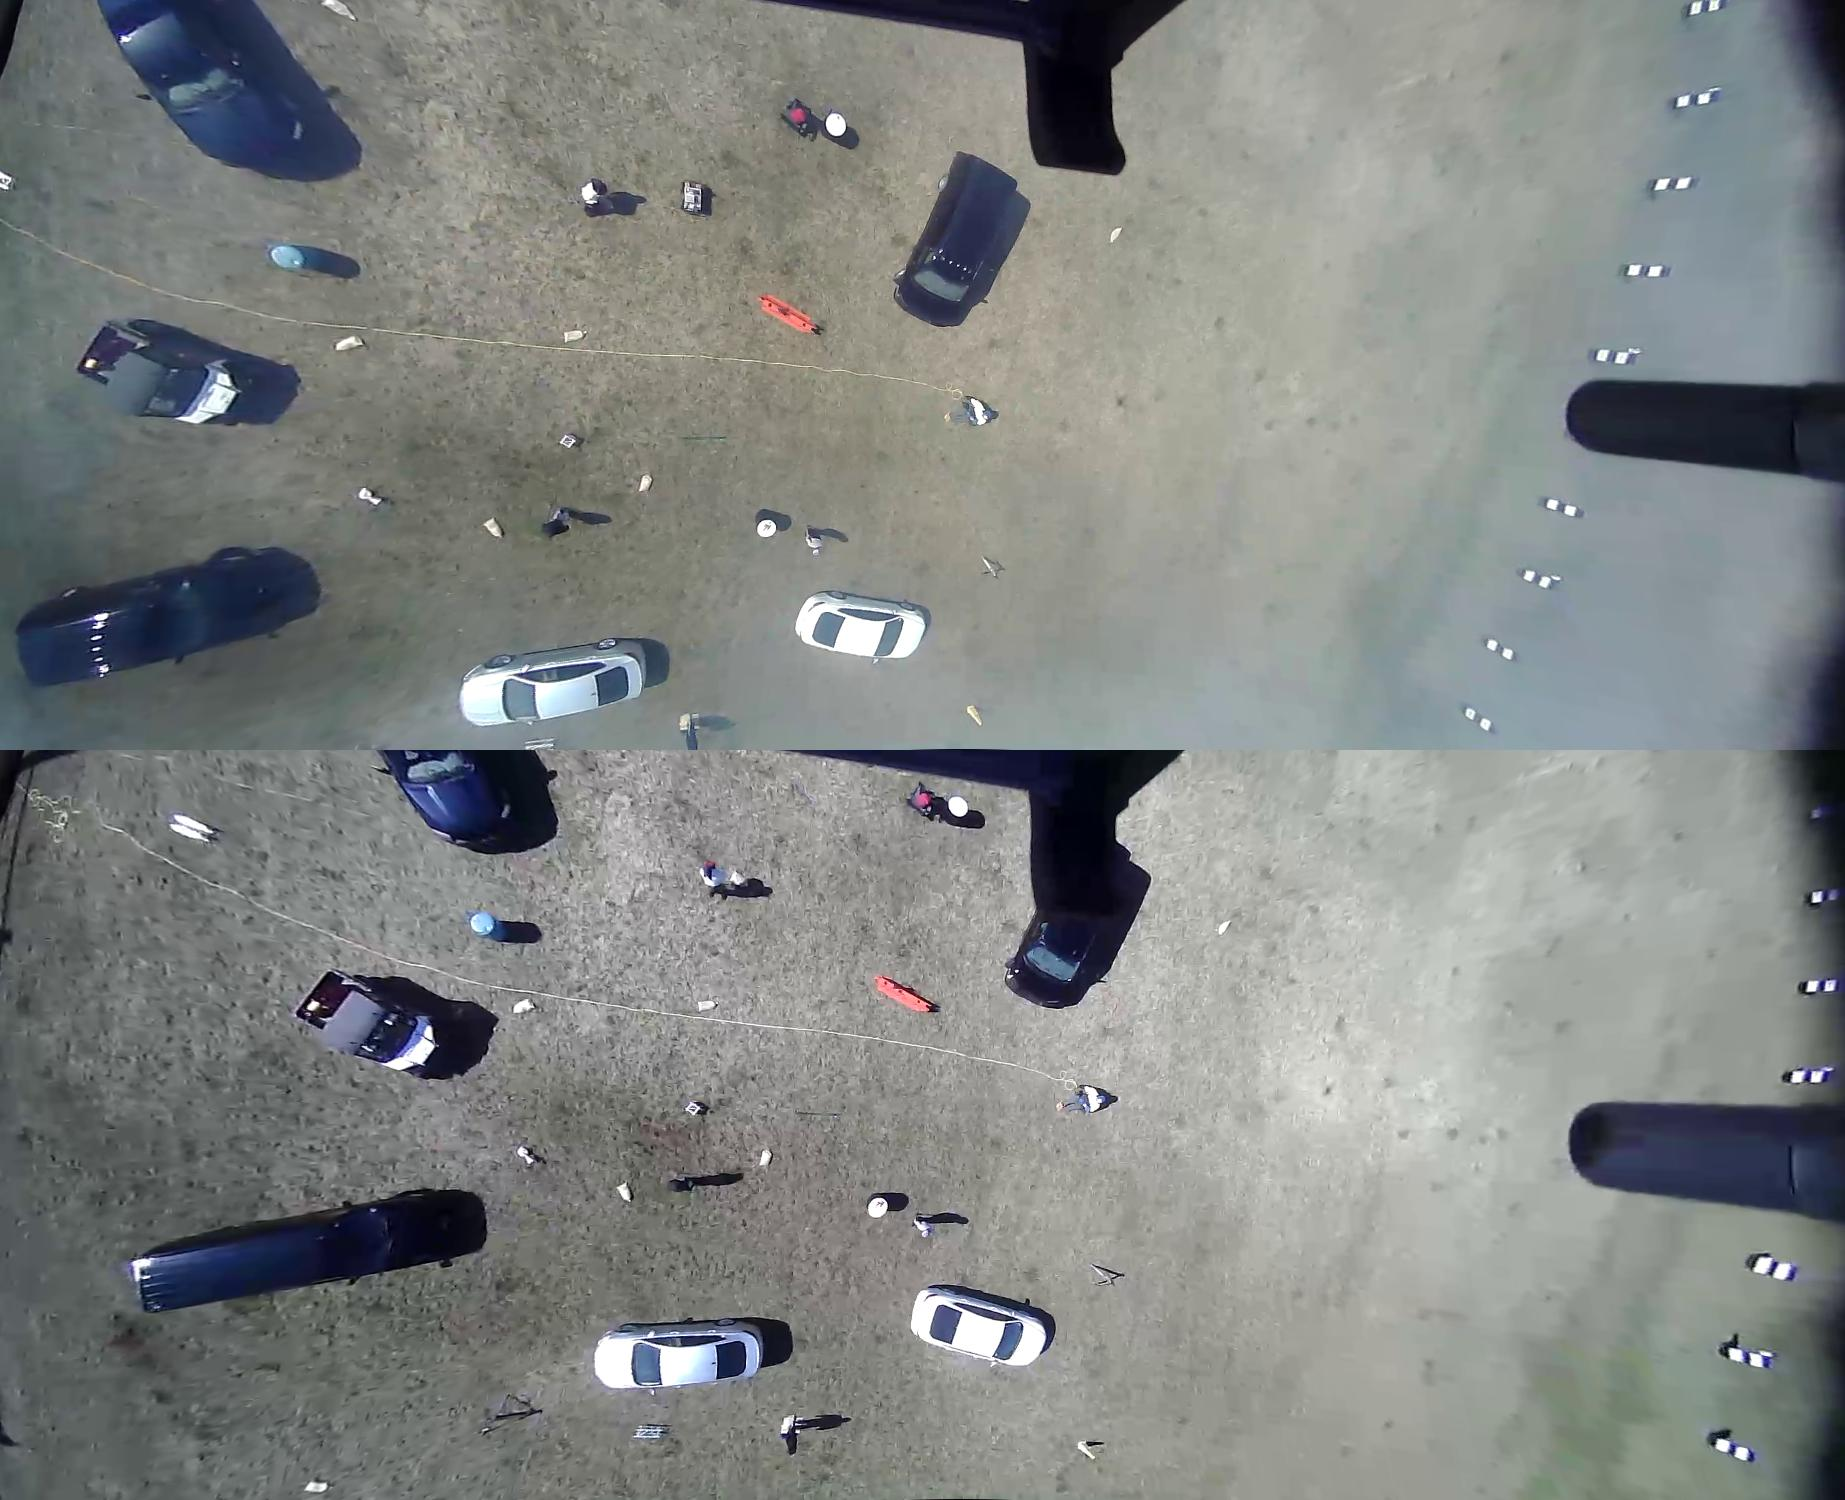

In [ ]:
image_path = os.path.join(haze_images, '035.jpg')
image = cv2.imread(image_path)
cv2_imshow(image)

In [ ]:
def visualize_groundtruth_image(img_path):
  '''
  Displays the image with the detected object boundaries marked.
  This method should be used for training images only as it tries
  to fetch the bounding box from the train data directory.

  Parameters:
          img_path : Path of the image
  '''
  image = cv2.imread(img_path)
  assert img_path in train_images_box_map, 'Image path not found in bounding box mapping dictionary'
  coords = train_images_box_map[img_path]
  for coord in coords:
    start_point = (int(coord[0]), int(coord[1]))
    end_point = (int(coord[2]), int(coord[3]))
    # Blue color in BGR
    color = (255, 0, 0)
      
    # Line thickness of 2 px
    thickness = 2

    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    cv2.rectangle(image, start_point, end_point, color, thickness)

  cv2_imshow(image)

In [ ]:
#The actual image has a height of 1500. The image
#is made up of two parts. The top half is the hazy image
#and the bottom half is that of a clear image.
#The actual test data will be that of a hazy image with the 
#height as (750, 1845)
im_height, im_width = 750, 1845

In [ ]:
def visualize_predicted_image(image_path, coords):
  '''
  Displays the image with the detected object boundaries marked

    Parameters:
            img_path : Path of the image
            coords : list of detected bounding boxes
  '''
  image = cv2.imread(image_path)
  #im_height, im_width = image.shape[:2]
  for coord in coords:
    ymin, xmin, ymax, xmax = coord[0]
    #The actual model used for detecting bounding box
    #returns scaled coordinates. Hence we are multiplying 
    #the coordinates by the image width and height
    start_point = (int(xmin*im_width)), (int(ymin*im_height))
    end_point = (int(xmax*im_width)), (int(ymax*im_height))
    # Blue color in BGR
    color = (255, 0, 0)
      
    # Line thickness of 2 px
    thickness = 2

    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    cv2.rectangle(image, start_point, end_point, color, thickness)

  cv2_imshow(image)

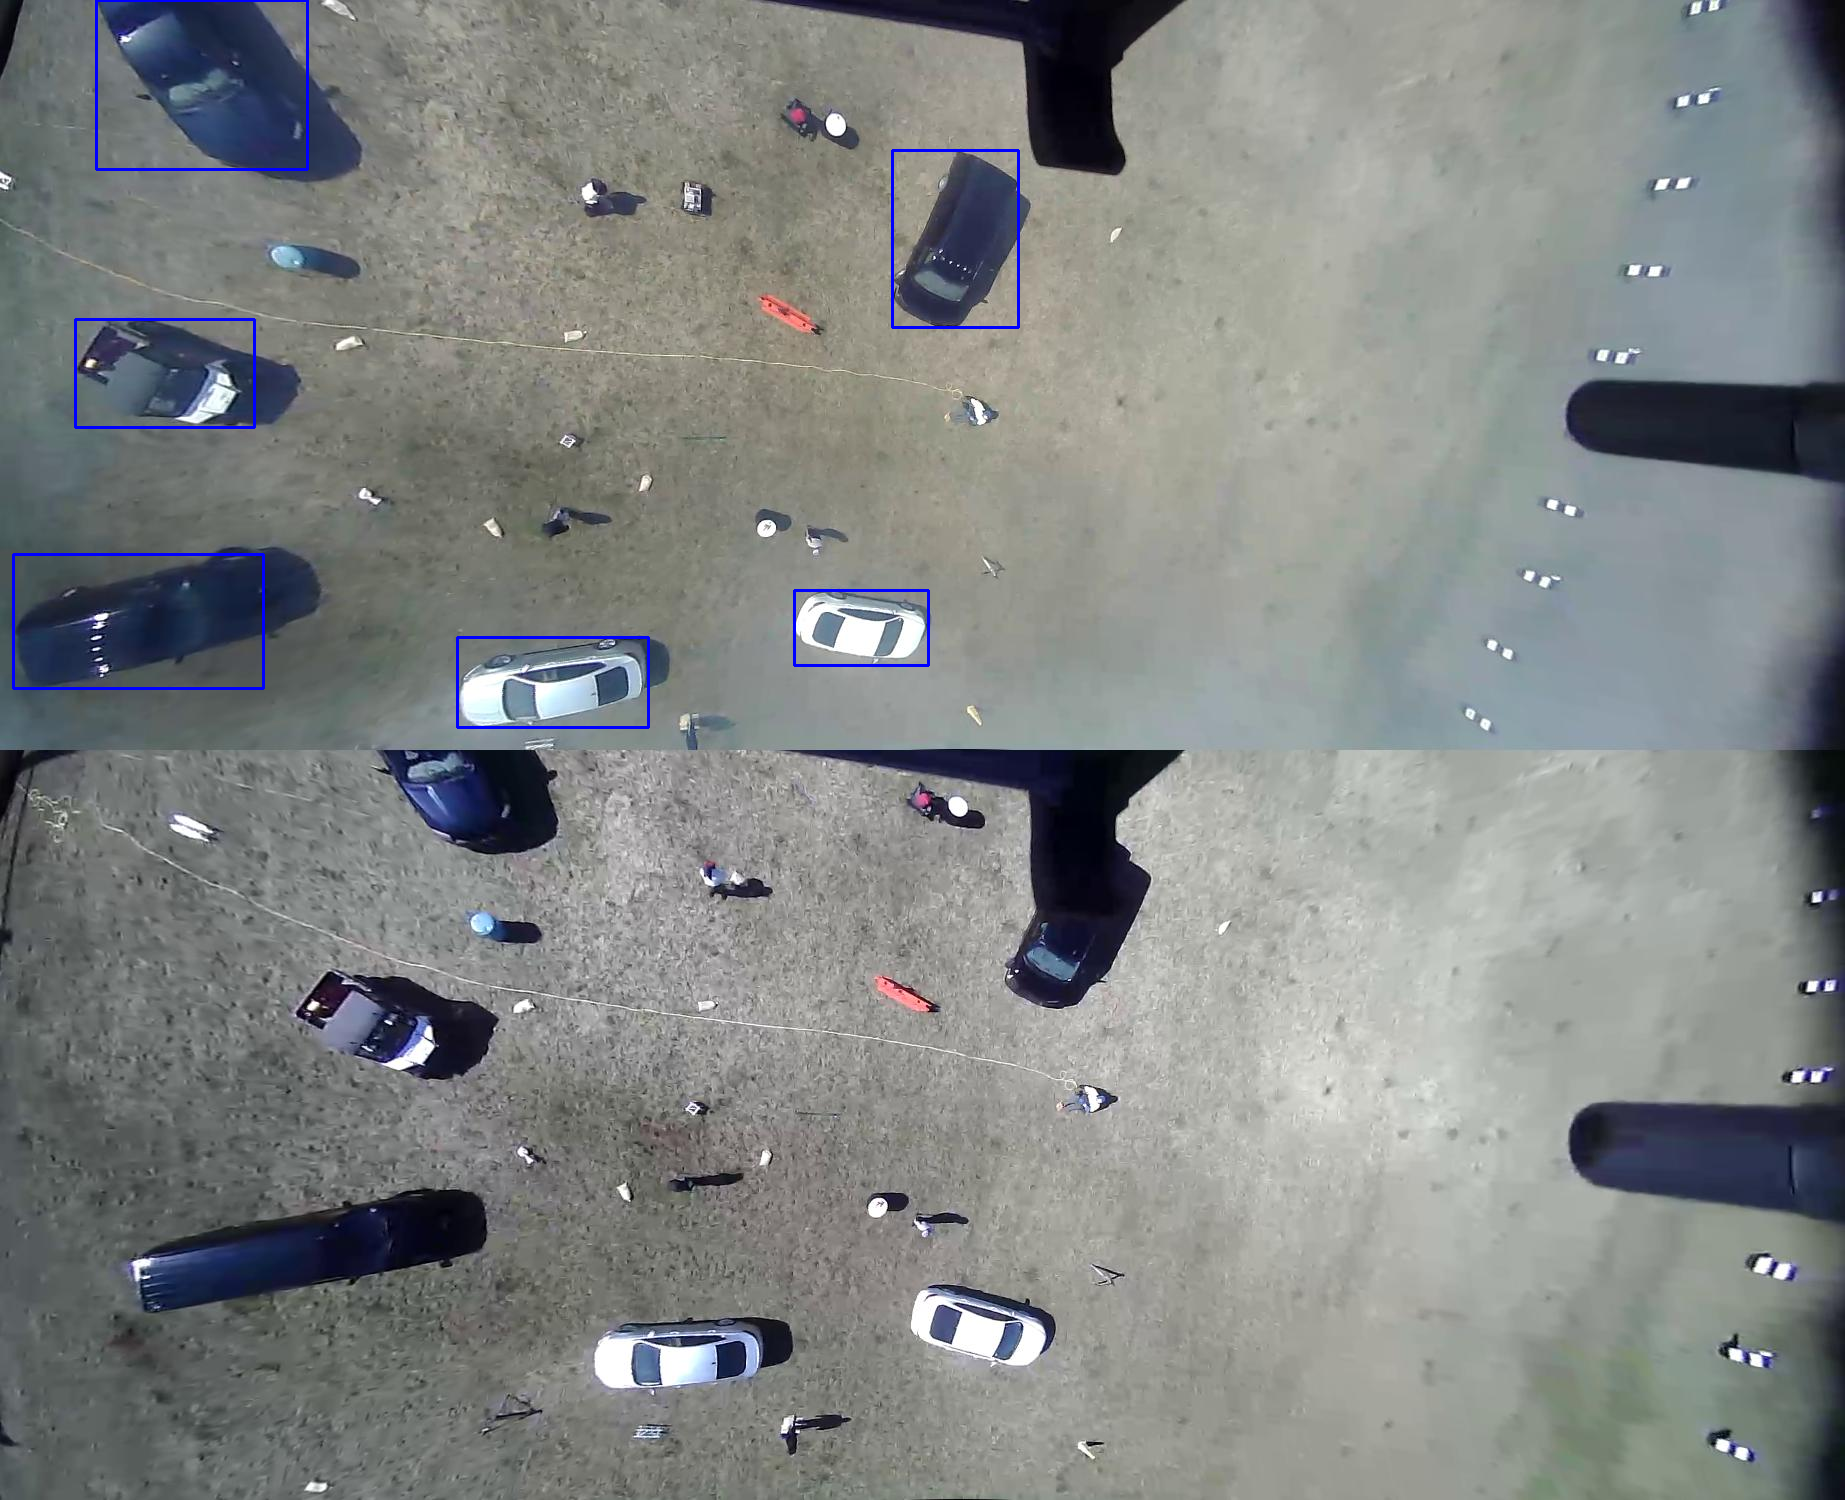

In [ ]:
visualize_groundtruth_image(image_path)

In [ ]:
def get_hazy_image(img_path):
  '''
  The image comprises of hazy image and clean image
  The top half is the hazy image and the bottom half is clean image

    Parameters:
            img_path : Path of the image

    Returns:
            The hazy image as a numpy array
  '''

  img = cv2.imread(img_path)
  cropped_image = img[:int(img.shape[0]/2)]
  return cropped_image

In [ ]:
hazy_image = get_hazy_image(image_path)
print(hazy_image.shape)

(750, 1845, 3)


# Model Inference

The below inference code is borrowed from the official tensorflow object detection [tutorial](https://www.tensorflow.org/hub/tutorials/object_detection). 

We are using a generic object detection model FasterRCNN+InceptionResNetV2 network to detect objects. This model detects all objects in an image.

In [ ]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# Print Tensorflow version
print(tf.__version__)

2.8.0


In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def filter_coords(result, threshold = 0):
  '''
    A helper method which extracts the bounding boxes and threshold confidence scores
    from the data structure returned from the pretrained model

    Parameters:
            result : Output of the pretrained tensor flow model
            threshold : Optional threshold confidence above which bounding boxes are selected
    Returns:
            The list of coordinates of the detected objects and the threshold score
  '''
  class_entities = result['detection_class_entities']
  detection_scores = result['detection_scores']
  bounding_boxes = result['detection_boxes']
  detection_boxes_with_thresholds = []
  for class_entity, detection_score, bounding_box in zip(class_entities, detection_scores, bounding_boxes):
    if class_entity in [b'Vehicle', b'Car'] and detection_score > threshold:
      detection_boxes_with_thresholds.append((bounding_box, detection_score))
  return detection_boxes_with_thresholds

In [ ]:
image_path = os.path.join(haze_images, '035.jpg')
image = get_hazy_image(image_path)
image = tf.convert_to_tensor(
    image
)
converted_img  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]

# todo: dehaze

try trident dehazing network

In [4]:
import torch
torch.__version__

'1.10.0+cu111'

In [5]:
!pip install tensorboardX
!pip freeze

     |████████████████████████████████| 125 kB 7.1 MB/s 
absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0


get original image size

In [ ]:
orig = cv2.imread('BPP_train/haze_train/050.jpg')
orig.shape #(750,1845,3)

(750, 1845, 3)

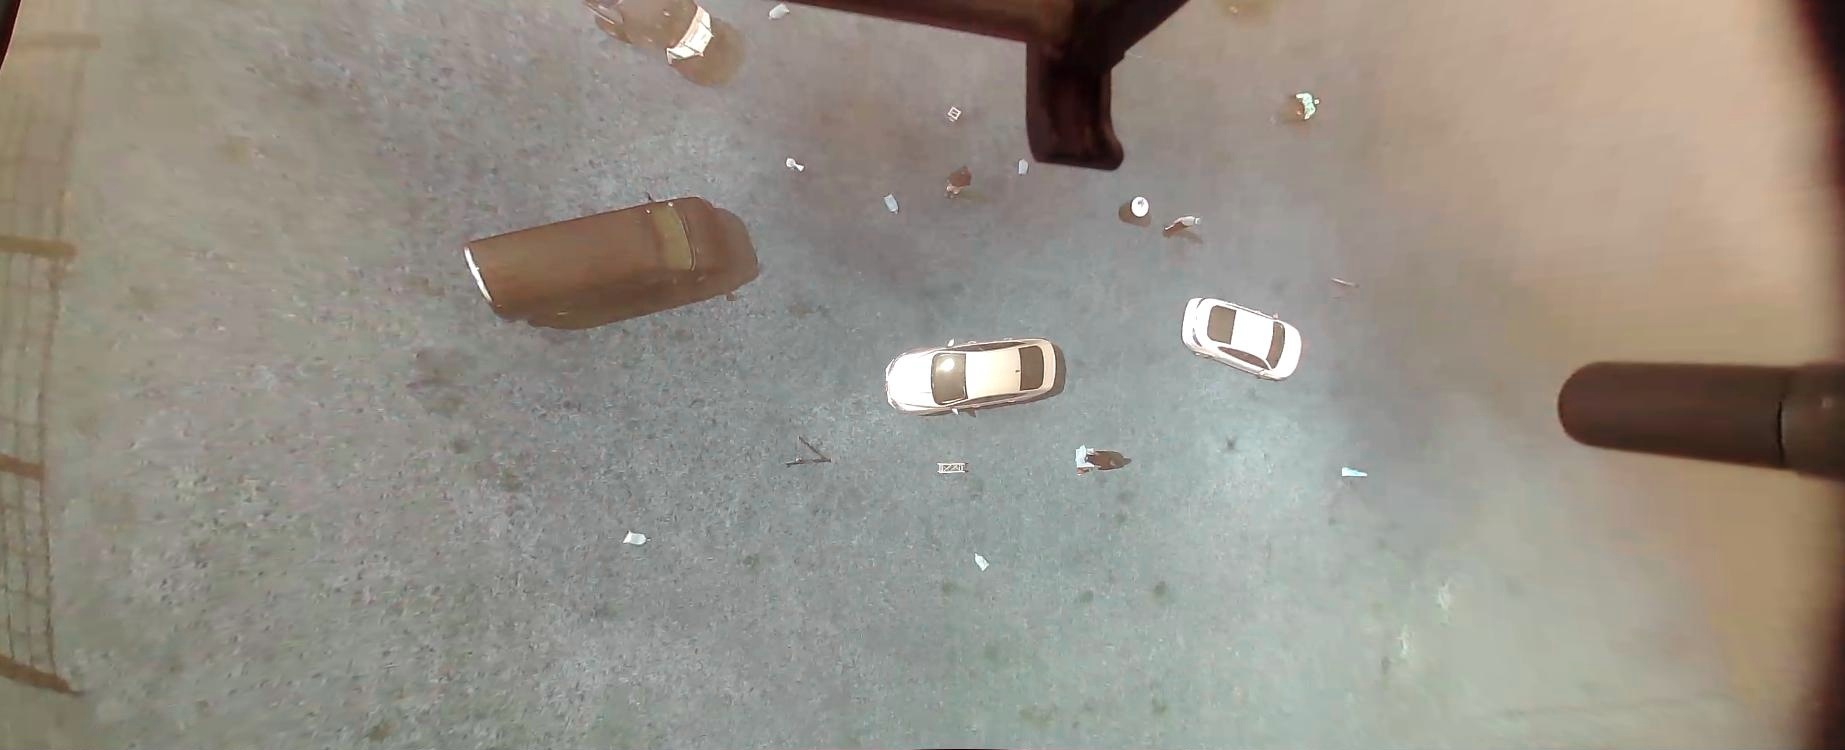

In [ ]:
cv2_imshow(orig)

get dehaze model image size

In [ ]:
modelimg = cv2.imread('NTIRE-2021-Dehazing-Two-branch/NTIRE2021_Test_Hazy/34.png')
modelimg.shape #(1200,1600,3)

(1200, 1600, 3)

In [ ]:
import PIL
from PIL import Image

with Image.open('BPP_train/haze_train/050.jpg') as im:
  resized = im.resize((1600,1200))

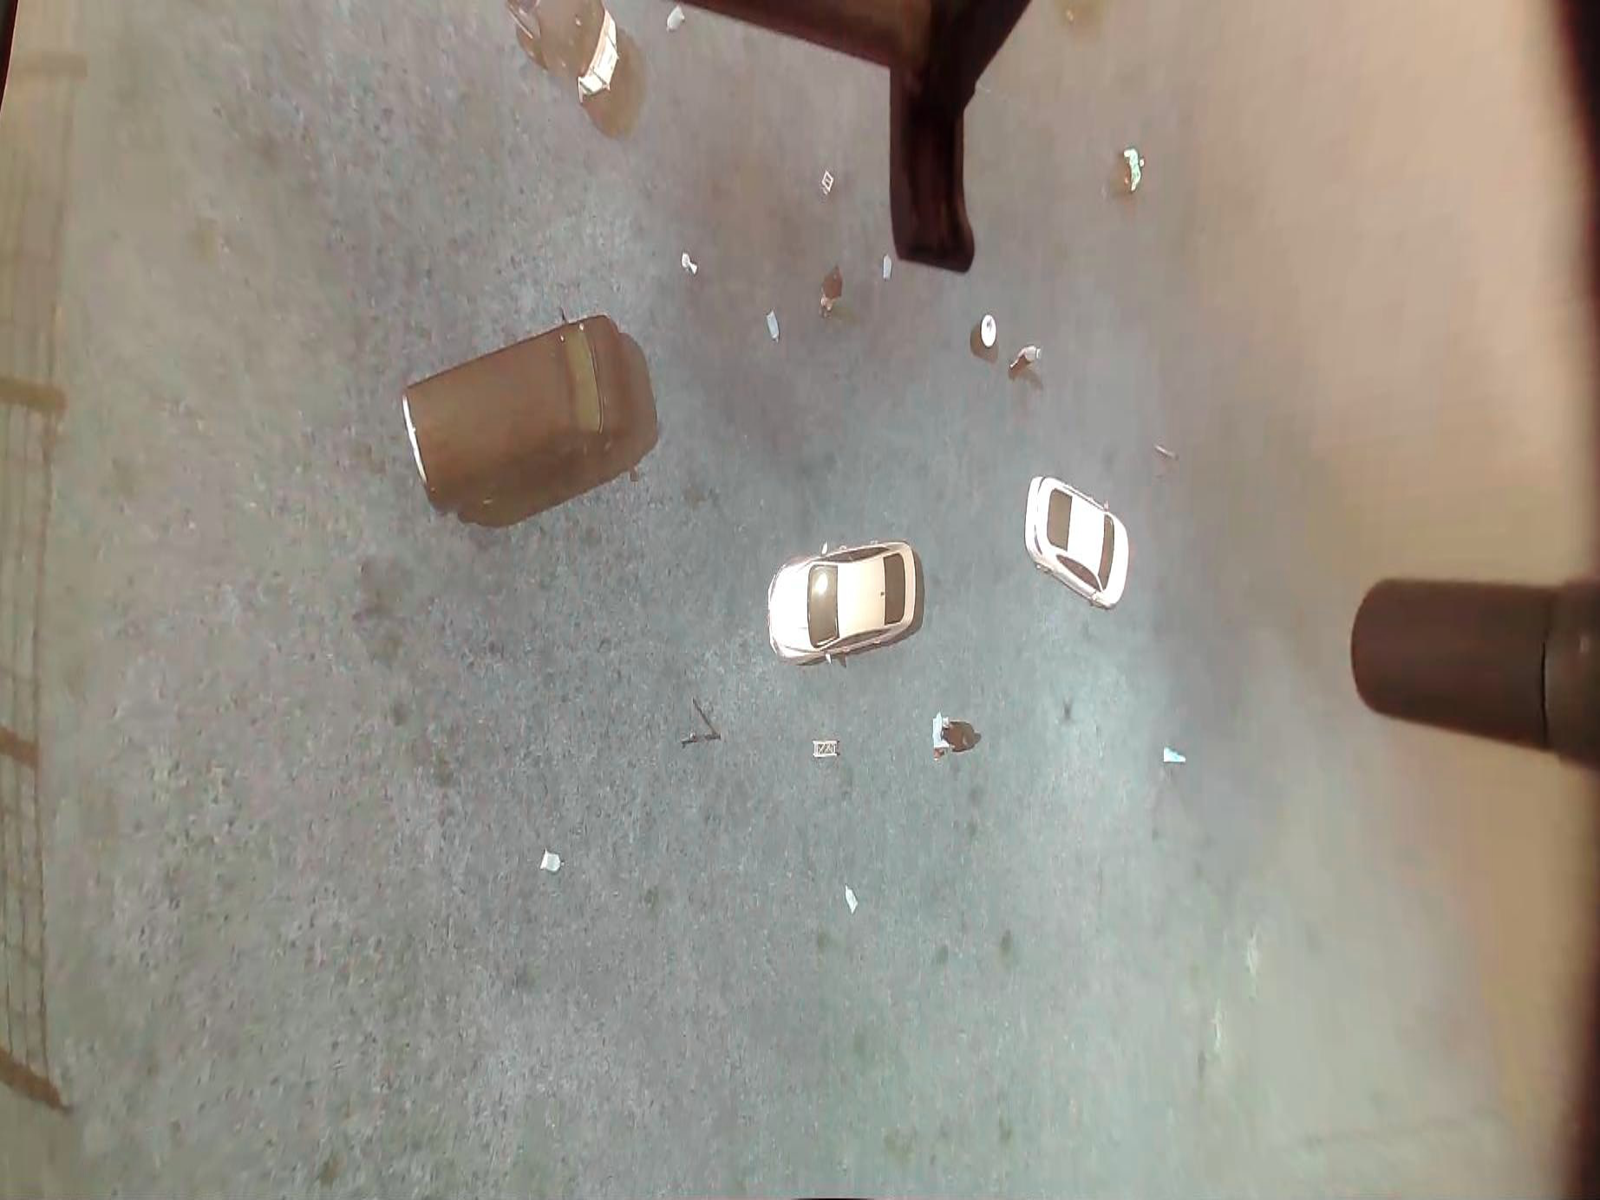

In [ ]:
resized

convert haze_images to correct size for dehazing model to dehaze

In [ ]:
imgs = glob(os.path.join('BPP_train/haze_train','*.jpg'))

for img in imgs:
  with Image.open(img) as i:
    resized = i.resize((1600,1200))
    # print(img)
    t = img.replace('haze_train','haze_train_resized')
    # inames.append(img.replace('BPP_train/haze_train',''))
    # print(t)
    os.makedirs(os.path.dirname(t),exist_ok=True)
    resized.save(t)

convert BPP_train/haze_train and BPP_train/dehaze_train to correct size for dehazing model to train

In [ ]:
%cd ..

/content/drive/.shortcut-targets-by-id/1NQ6kbfawC4kjJNbWUW0uuMYnJQJg17UW/COMS4995_Competition


In [ ]:
# hazy = glob(os.path.join('BPP_train/haze_train','*.jpg'))
clean = glob(os.path.join('BPP_train/dehaze_train','*.jpg'))

# for h in hazy:
#   with Image.open(h) as i:
#     r = i.resize((1600,1200))
#     t = h.replace('images','images_resized')
#     os.makedirs(os.path.dirname(t),exist_ok=True)
#     r.save(t)

for c in clean:
  with Image.open(c) as i:
    r = i.resize((1600,1200))
    t = c.replace('dehaze_train','dehaze_train_resized')
    os.makedirs(os.path.dirname(t),exist_ok=True)
    r.save(t)

hazy = glob(os.path.join('BPP_train/haze_test','*.jpg'))
clean = glob(os.path.join('BPP_train/dehaze_test','*.jpg'))

for h in hazy:
  with Image.open(h) as i:
    r = i.resize((1600,1200))
    t = h.replace('test','test_resized')
    os.makedirs(os.path.dirname(t),exist_ok=True)
    r.save(t)

for c in clean:
  with Image.open(c) as i:
    r = i.resize((1600,1200))
    t = c.replace('test','test_resized')
    os.makedirs(os.path.dirname(t),exist_ok=True)
    r.save(t)

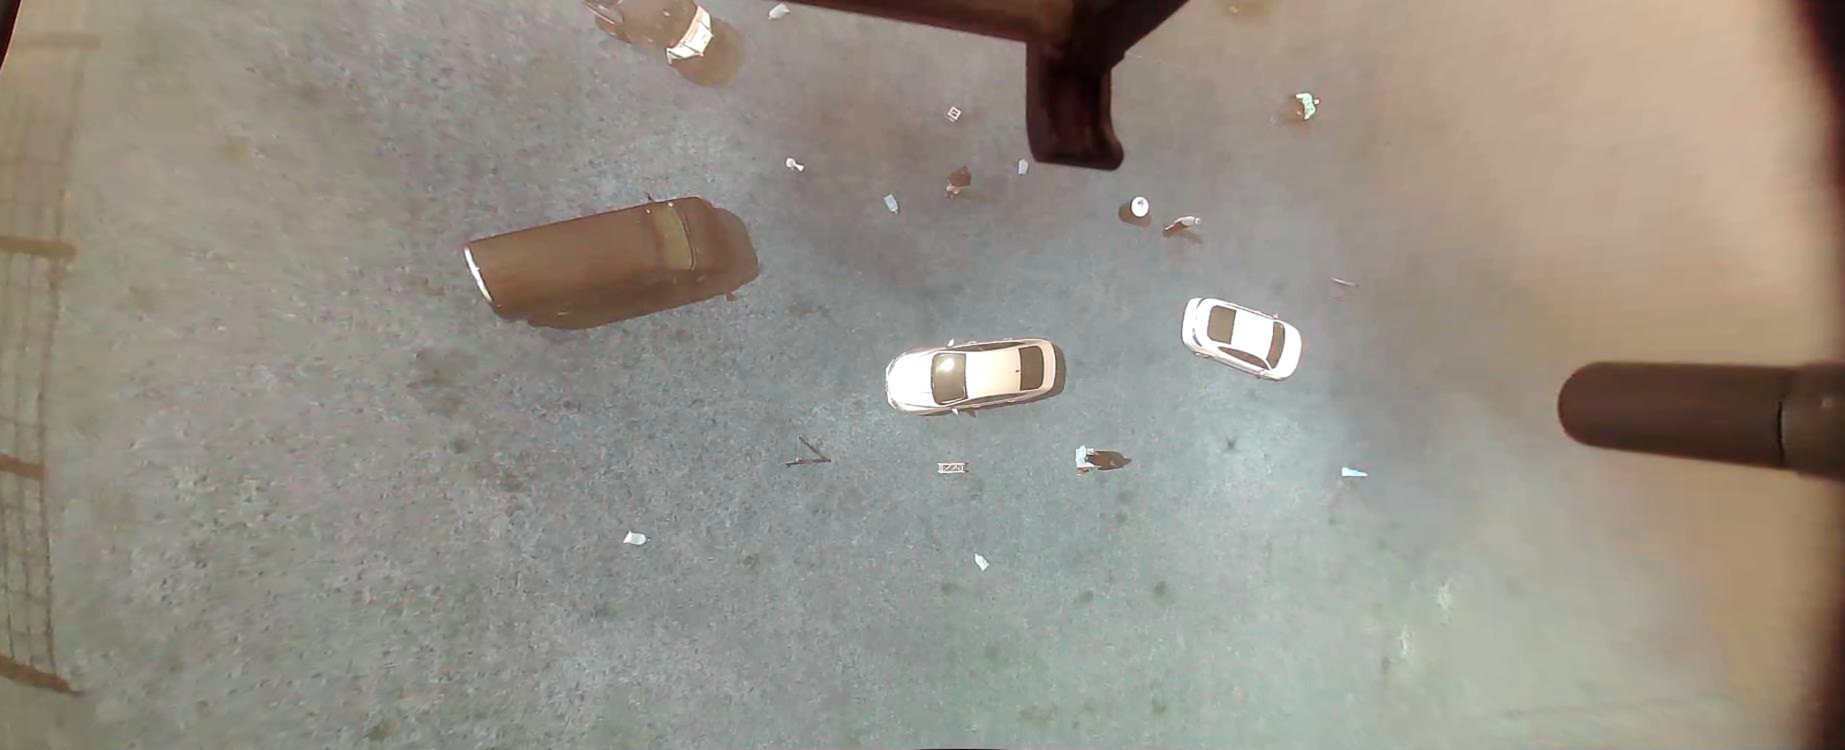

In [ ]:
resized.resize((1845,750))

train the dehazing model on our dataset

In [6]:
%cd NTIRE-2021-Dehazing-Two-branch

/content/drive/.shortcut-targets-by-id/1NQ6kbfawC4kjJNbWUW0uuMYnJQJg17UW/COMS4995_Competition/NTIRE-2021-Dehazing-Two-branch


In [ ]:
!python train.py --data_dir ../BPP_train -train_batch_size 4 --model_save_dir train_result --pkl epoch5.pkl #at epoch 5 at epoch 15 at epoch20 at epoch30

MyEnsembleNet parameters: 50353285
# Discriminator parameters: 5215425
--- weight loaded ---
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
0
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3792: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")
we are testing on epoch: 0
0 dehazed 17.020608855830854 0.7759347806665411
1
2
3
4
5

run the dehazing model to dehaze the resized images

In [10]:
!python test.py --model_save_dir ../BPP_train/dehazed_haze_train_resized --pkl epoch30.pkl

MyEnsembleNet parameters: 50353285
--- pkl weights loaded ---
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3792: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")
testing 1/159
testing 11/159
testing 21/159
testing 31/159
testing 41/159
testing 51/159
testing 61/159
testing 71/159
testing 81/159
testing 91/159
testing 101/159
testing 111/159
testing 121/159
testing 131/159
testing 141/159
testing 151/159
running time per image:  0.23530157257176046


convert the dehazed train images back to original size

In [1]:
!pwd

/content


In [11]:
%cd ..

/content/drive/.shortcut-targets-by-id/1NQ6kbfawC4kjJNbWUW0uuMYnJQJg17UW/COMS4995_Competition


In [12]:
imgs = glob(os.path.join('BPP_train/dehazed_haze_train_resized','*.jpg'))

for img in imgs:
  with Image.open(img) as i:
    resized = i.resize((1845,750))
    t = img.replace('_resized','')
    os.makedirs(os.path.dirname(t),exist_ok=True)
    resized.save(t)

In [ ]:
result = detector(converted_img)

result = {key:value.numpy() for key,value in result.items()}

NameError: ignored

In [ ]:
!pwd

/content/drive/MyDrive


In [ ]:
f = filter_coords(result)
# print(result)
print(f)

[(array([0.41485408, 0.03782623, 0.5642953 , 0.15535095], dtype=float32), 0.07434935), (array([0.790502  , 0.42975625, 0.8845717 , 0.50237346], dtype=float32), 0.04549852), (array([0.34353286, 0.88096416, 0.37556648, 0.9052551 ], dtype=float32), 0.018413818), (array([0.12242649, 0.42118305, 0.19211273, 0.4618923 ], dtype=float32), 0.015229598), (array([0.42374626, 0.04047492, 0.5663959 , 0.16262242], dtype=float32), 0.01306405), (array([0.79208624, 0.42963973, 0.8869669 , 0.5022015 ], dtype=float32), 0.011504947), (array([0.        , 0.16626349, 0.9720507 , 1.        ], dtype=float32), 0.01147899), (array([0.6987532 , 0.43282157, 0.731435  , 0.4583856 ], dtype=float32), 0.009091302), (array([0.12413686, 0.4219357 , 0.17754936, 0.443862  ], dtype=float32), 0.00815998)]


If you print the result entity you will see a dictionary object. The keys of the dictionary are the type of objects detected, the bounding boxes of the object and the threshold scores of the image.

As you can see our model doesn't do very well.

In [ ]:
visualize_predicted_image(image_path, f)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image_to_predicted_bb = {}

In [ ]:
from os import listdir
from os.path import isfile, join

dry_run_folder = os.path.join(root, 'dry-run-1')
dry_run_images = [join(dry_run_folder, f) for f in listdir(dry_run_folder) if isfile(join(dry_run_folder, f))]
print(len(dry_run_images))
print(dry_run_images)

60
['/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_044.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_053.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_063.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/186.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_035.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_028.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/097.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_048.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_024.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/029.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_046.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_059.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_034.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/new_054.jpg', '/gdrive/MyDrive/COMS4995_Competition/train/dry-run-1/16

Let's run our model on the dry_run_images.

In [ ]:
for image_path in dry_run_images:
  image = cv2.imread(image_path)
  image = tf.convert_to_tensor(
      image
  )
  image  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]

  result = detector(image)

  result = {key:value.numpy() for key,value in result.items()}

  coords = filter_coords(result, 0.0)

  image_to_predicted_bb[image_path] = coords

In [ ]:
image_to_predicted_bb[image_path]

[(array([0.        , 0.05835229, 1.        , 1.        ], dtype=float32),
  0.29178149),
 (array([0.43716246, 0.21258005, 0.4894988 , 0.23019072], dtype=float32),
  0.08018052),
 (array([0.        , 0.00429535, 1.        , 0.5993279 ], dtype=float32),
  0.06755807),
 (array([0.89139944, 0.68748456, 0.99858975, 0.73563796], dtype=float32),
  0.050114706),
 (array([0.7352888 , 0.5831392 , 0.7970135 , 0.60247374], dtype=float32),
  0.04856969),
 (array([0.47338387, 0.7503224 , 0.54836166, 0.7758729 ], dtype=float32),
  0.041577168),
 (array([0.7368973 , 0.5805711 , 0.8389825 , 0.60448045], dtype=float32),
  0.03026773),
 (array([0.37278792, 0.19971478, 0.48950395, 0.2349655 ], dtype=float32),
  0.030229386),
 (array([0.3883406 , 0.20458423, 0.46179736, 0.22980253], dtype=float32),
  0.029641131),
 (array([0.41699594, 0.21047361, 0.4933086 , 0.23217137], dtype=float32),
  0.024844894),
 (array([0.7809106 , 0.5888077 , 0.84326756, 0.6079577 ], dtype=float32),
  0.01775231),
 (array([0.74732

Let's generate our result folder structure. We run our model on haze_images folder. We generate a text file for each image. Each line in the text file has the following format.

'vehicle {x_min_coordinate} {y_min_coordinate} {x_max_coordinate} {y_max_coordinate} {threshold}'

Upload a zip file of the results folder to get on the leader board.

In [ ]:
results = os.path.join(root, 'results')

Path(results).mkdir(parents=True, exist_ok=True)

for image in image_to_predicted_bb:
  filename = Path(image).stem
  new_file = os.path.join(results, f'{filename}.txt')
  coords = image_to_predicted_bb[image]
  try:
    os.remove(filename)
  except OSError:
    pass
  f = open(new_file, "w+")
  for coord in coords:
    ymin, xmin, ymax, xmax = coord[0]
    threshold = coord[1]
    format_string = f'vehicle {xmin*im_width} {ymin*im_height} {xmax*im_width} {ymax*im_height} {threshold}\n'
    f = open(new_file, "a+")
    f.write(format_string)
    f.close()

Points to note:



1.   We are using a pretrained model which detects all objects. We are just filtering the objects with the type as vehicle.
2.   We haven't accounted for the labeled bounding box coordinates mapping of the image.
3.   We haven't used the clean part of the images.



Things you can try:



1.   You can design a model which trains images to predict the bounding box coordinates of the model by making use of the ground truth bounding box coordinates.
2.   You can use the clearer image to obtain a slightly clearer representation of the hazy image.



This is no way an exhaustive list. You might get a better idea by reading relevant research papers. Good luck!